# Landsat5 analysis for spots, gaps and labyrinths from 1988 to 2003

Use data taken in yearly basis to the 3 default spots. The analysis is the following:

- Time series of the 15 years with network centrality values and precipitation
- Autocorrelation investigation
- Dynamic factor fit of the 3 datapoints.

In [1]:
from matplotlib import pyplot as plt
import datetime 
import pandas as pd
import os
%matplotlib inline
from pyveg.src.data_analysis_utils import variable_read_json_to_dataframe, drop_veg_outliers, smooth_veg_data, make_time_series, create_lat_long_metric_figures, convert_to_geopandas, coarse_dataframe, write_slimmed_csv, get_AR1_parameter_estimate


Helper functions

In [2]:

def get_kendell_tau(ys):
    """
    Kendall's tau gives information about the trend of the time series.
    It is just a rank correlation test with one variable being time 
    (or the vector 1 to the length of the time series), and the other 
    variable being the data itself. A tau value of 1 means that the 
    time series is always increasing, whereas -1 mean always decreasing,
    and 0 signifies no overall trend.

    Parameters
    ----------
    ys: array
        Input time series data.

    Returns
    -------
    float
        The value of tau.
    float
        The p value of the rank correlation test.
    """

    from scipy.stats import kendalltau

    # calculate Kendall tau
    tau, p = kendalltau(range(len(ys)), ys)

    return tau, p

def plot_smoothed_time_series(dfs,range_axis=[-750, -500]):
    """
    Given a dict of DataFrames, of which each row corresponds to
    a different time point (constructed with `make_time_series`),
    plot the time series of each DataFrame on the same plot. The
    data is assumed to have been previously smoothed, and so the 
    smoothed and unsmoothed offset50 valeus are plotted.

    Parameters
    ----------
    dfs : dict of DataFrame
        The time-series results averaged over sub-locations.

    output_dir : str
        Directory to save the plot in.
    """

    for collection_name, df in dfs.items():
        if collection_name == 'COPERNICUS/S2' or 'LANDSAT' in collection_name:

            # extract x values and convert to datetime objects
            veg_xs = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in df.index]

            # extract raw means
            veg_means = df['offset50_mean']

            # extract smoothed mean, std, and ci
            veg_means_smooth = df['offset50_smooth_mean']
            veg_stds_smooth = df['offset50_smooth_std']
            veg_ci = df['ci_mean']

            # extract rainfall data
            precip_xs = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dfs['ECMWF/ERA5/MONTHLY'].index]
            precip = dfs['ECMWF/ERA5/MONTHLY']['total_precipitation']

            # create a figure
            fig, ax = plt.subplots(figsize=(15,5))
            plt.xlabel('Time', fontsize=12)

            # set up veg y axis
            color = 'tab:green'
            ax.set_ylabel(f'{collection_name} Offset50', color=color, fontsize=12)
            ax.tick_params(axis='y', labelcolor=color)

            # plot unsmoothed vegetation means
            ax.plot(veg_xs, veg_means, label='Unsmoothed', linewidth=1, color='dimgray', linestyle='dotted')
            
            # plot LOESS smoothed vegetation means and std
            ax.plot(veg_xs, veg_means_smooth, label='Smoothed', linewidth=2, color='green')
            ax.fill_between(veg_xs, veg_means_smooth-veg_stds_smooth, veg_means_smooth+veg_stds_smooth, facecolor='green', alpha=0.1, label='Std Dev')
            
            # plot ci of the smoothed mean
            ax.plot(veg_xs, veg_means_smooth+veg_ci, label='99% CI', linewidth=1, color='green', linestyle='dashed')
            ax.plot(veg_xs, veg_means_smooth-veg_ci, linewidth=1, color='green', linestyle='dashed')
            ax.set_ylim(range_axis)

            # plot legend
            plt.legend(loc='upper left')
            
            # duplicate x-axis for preciptation
            ax2 = ax.twinx()
            color = 'tab:blue'
            ax2.set_ylabel(f'Precipitation', color=color, fontsize=12)
            ax2.tick_params(axis='y', labelcolor=color)

            # plot precipitation
            ax2.plot(precip_xs, precip, linewidth=2, color=color, alpha=0.75)

            print (precip.shape)
            print (veg_means.shape)
            # add veg-precip correlation
            raw_corr = veg_means.corr(precip)
            smoothed_corr = veg_means_smooth.corr(precip)

            textstr = f'$r={smoothed_corr:.2f}$ (${raw_corr:.2f}$ unsmoothed)'
            ax2.text(0.13, 0.95, textstr, transform=ax2.transAxes, fontsize=14, verticalalignment='top')

            # add autoregression info
            unsmoothed_ar1 = get_AR1_parameter_estimate(veg_means)
            smoothed_ar1 = get_AR1_parameter_estimate(veg_means_smooth)
            textstr = f'AR$(1)={smoothed_ar1:.2f}$ (${unsmoothed_ar1:.2f}$ unsmoothed)'
            ax2.text(0.35, 0.95, textstr, transform=ax2.transAxes, fontsize=14, verticalalignment='top')

            # add Kendall tau
            tau, p = get_kendell_tau(veg_means)
            tau_smooth, p_smooth = get_kendell_tau(veg_means_smooth)
            textstr = f'$\\tau={tau_smooth:.2f}$ (${tau:.2f}$ unsmoothed)'
            ax2.text(0.62, 0.95, textstr, transform=ax2.transAxes, fontsize=14, verticalalignment='top')

            # layout
            fig.tight_layout()

           


           

In [3]:

def resample_time_series_sum(df, col_name="offset50",period = "D"):
    """
    Resample and interpolate a time series dataframe so we have one row
    per day (useful for FFT)

    Parameters
    ----------
    df: DataFrame with date as index
    col_name: string, identifying the column we will pull out

    Returns
    -------
    new_series: pandas Series with datetime index, and one column, one row per day
    """
    series = df[col_name]
    # just in case the index isn't already datetime type
    series.index = pd.to_datetime(series.index)

    # resample to get one row per day
    rseries = series.resample(period).sum()
    
    new_series = rseries.interpolate()

    return new_series


def resample_time_series(df, col_name="offset50",period = "D"):
    """
    Resample and interpolate a time series dataframe so we have one row
    per day (useful for FFT)

    Parameters
    ----------
    df: DataFrame with date as index
    col_name: string, identifying the column we will pull out

    Returns
    -------
    new_series: pandas Series with datetime index, and one column, one row per day
    """
    series = df[col_name]
    # just in case the index isn't already datetime type
    series.index = pd.to_datetime(series.index)

    # resample to get one row per day
    rseries = series.resample(period).mean()
    
    new_series = rseries.interpolate()

    return new_series

In [4]:
def read_file_create_ts_prep(input_dir):

    output_dir = os.path.join(input_dir, 'analysis')

    # check file exists
    json_summary_path = os.path.join(input_dir, 'results_summary.json')
    dfs = variable_read_json_to_dataframe(json_summary_path)
    
    
    dfs = dfs['ECMWF/ERA5/MONTHLY']
    # drop outliers and smooth results
    
    return dfs

In [5]:
def read_file_create_ts(input_dir, prepicipitation, prep_name):

    output_dir = os.path.join(input_dir, 'analysis')

    # check file exists
    json_summary_path = os.path.join(input_dir, 'results_summary.json')
    dfs = variable_read_json_to_dataframe(json_summary_path)
    
    dfs[prep_name] = prepicipitation
    
    dfs = drop_veg_outliers(dfs, sigmas=3) # not convinced this is really helping much

    # drop outliers and smooth results
    
    time_series_dfs = make_time_series(smooth_veg_data(dfs.copy(), n=3)) # increase smoothing with n>5
    
    plot_smoothed_time_series(time_series_dfs)

    #time_series_dfs = make_time_series(dfs)
    
    offsets_smooth = resample_time_series(time_series_dfs['LANDSAT/LT05/C01/T1_SR'], col_name="offset50_smooth_mean",period="Y")
    offsets = resample_time_series(time_series_dfs['LANDSAT/LT05/C01/T1_SR'], col_name="offset50_mean",period="Y")

    return offsets, offsets_smooth


# Time series analysis

In [6]:
input_dir_prep_gaps = '/Users/crangelsmith/PycharmProjects/GEE_DATA/ERA5_GAPS/__2020-04-06_16-57-32/'
input_dir_prep_labs = '/Users/crangelsmith/PycharmProjects/GEE_DATA/ERA5_Labs/__2020-04-06_16-51-18/'
input_dir_prep_spots = '/Users/crangelsmith/PycharmProjects/GEE_DATA/ERA5_Spots/__2020-04-06_16-45-22/'

In [7]:
input_dir_spots = '/Users/crangelsmith/PycharmProjects/GEE_DATA/Landsat5_1988_2003_SPOTS/__2020-04-02_17-52-34/'
input_dir_laberynths = '/Users/crangelsmith/PycharmProjects/GEE_DATA/Landsat5_1988_2003_LABYRINTHS/__2020-04-02_18-04-04/'
input_dir_gaps = '/Users/crangelsmith/PycharmProjects/GEE_DATA/Landsat5_1988_2003_GAPS/__2020-04-02_18-08-05/'

In [8]:
prepicipitation_gaps = read_file_create_ts_prep(input_dir_prep_gaps)
prepicipitation_labs = read_file_create_ts_prep(input_dir_prep_labs)
prepicipitation_spots = read_file_create_ts_prep(input_dir_prep_spots)



## Spots 

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(15,)
(15,)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            AutoReg Model Results                             
Dep. Variable:          offset50_mean   No. Observations:                   15
Model:                     AutoReg(1)   Log Likelihood                 -49.519
Method:               Conditional MLE   S.D. of innovations              8.316
Date:                Tue, 07 Apr 2020   AIC                              4.665
Time:                        12:02:30   BIC                              4.802
Sample:                             1   HQIC                             4.652
                                   15                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         -649.1602    160.324     -4.049      0.000    -963.390    -334.930
offset50_mean.L1    -0.0171      0.251     -0.068      0.946      -0.509       0.475
                            

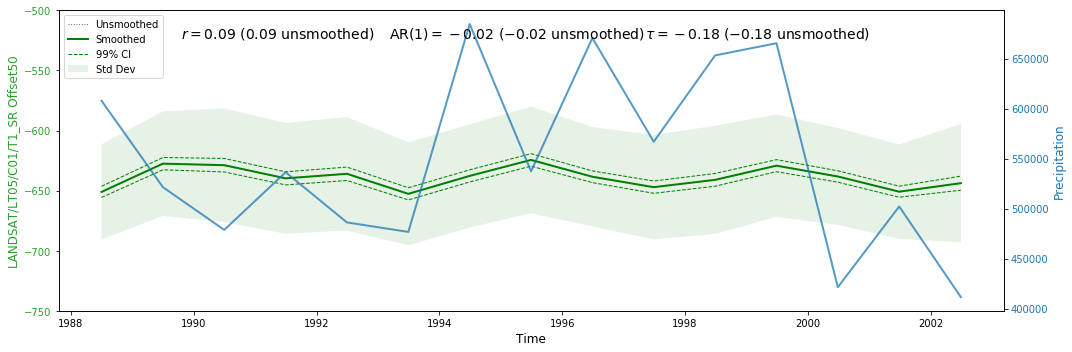

In [9]:
offsets_spots, offsets_spots_smooth = read_file_create_ts(input_dir_spots,prepicipitation_spots,'ECMWF/ERA5/MONTHLY')

## Gaps

(15,)
(15,)
                            AutoReg Model Results                             
Dep. Variable:          offset50_mean   No. Observations:                   15
Model:                     AutoReg(1)   Log Likelihood                 -54.938
Method:               Conditional MLE   S.D. of innovations             12.246
Date:                Tue, 07 Apr 2020   AIC                              5.439
Time:                        12:02:48   BIC                              5.576
Sample:                             1   HQIC                             5.426
                                   15                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         -446.4521    155.750     -2.866      0.004    -751.717    -141.187
offset50_mean.L1     0.2574      0.259      0.995      0.320      -0.250       0.765
                

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


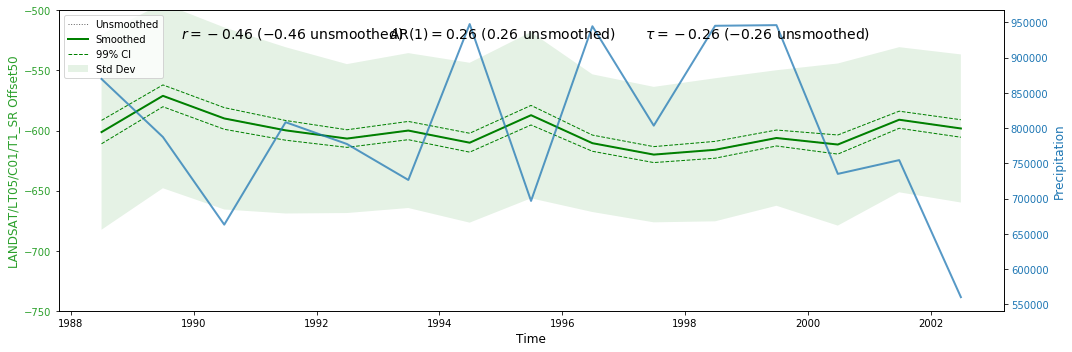

In [10]:
offsets_gaps, offsets_gaps_smooth = read_file_create_ts(input_dir_gaps,prepicipitation_gaps,'ECMWF/ERA5/MONTHLY')


## Labyrinths

(15,)
(15,)
                            AutoReg Model Results                             
Dep. Variable:          offset50_mean   No. Observations:                   15
Model:                     AutoReg(1)   Log Likelihood                 -49.330
Method:               Conditional MLE   S.D. of innovations              8.204
Date:                Tue, 07 Apr 2020   AIC                              4.638
Time:                        12:03:07   BIC                              4.775
Sample:                             1   HQIC                             4.625
                                   15                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         -477.9805    130.502     -3.663      0.000    -733.760    -222.201
offset50_mean.L1     0.1985      0.219      0.905      0.366      -0.231       0.628
                

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


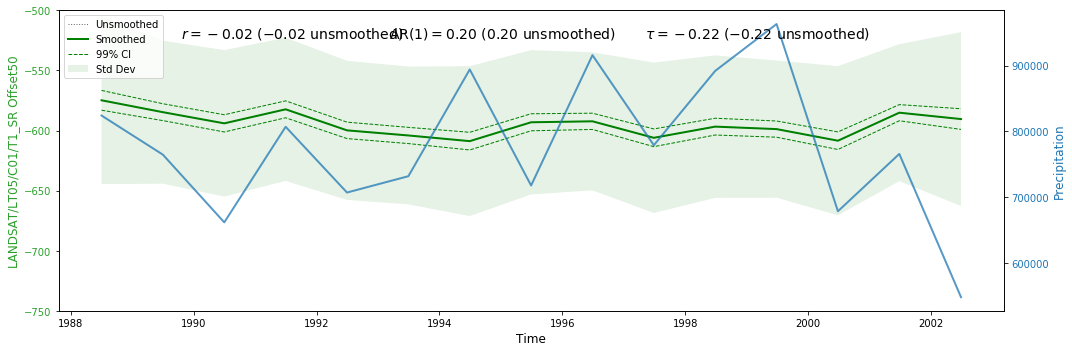

In [11]:
offsets_labs, offsets_labs_smooth = read_file_create_ts(input_dir_laberynths,prepicipitation_labs,'ECMWF/ERA5/MONTHLY')

## Autocorrelations

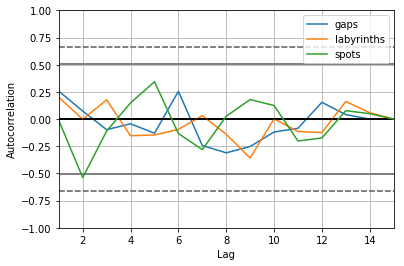

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(offsets_gaps,label='gaps')
autocorrelation_plot(offsets_labs,label='labyrinths')
autocorrelation_plot(offsets_spots,label='spots')
plt.show()

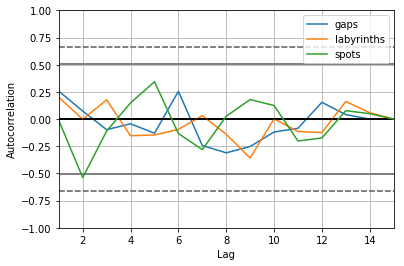

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(offsets_gaps_smooth,label='gaps')
autocorrelation_plot(offsets_labs_smooth,label='labyrinths')
autocorrelation_plot(offsets_spots_smooth,label='spots')
plt.show()

# Dynamic factor analysis for 3 locations

## Smoothed time-series

In [14]:
df1 = pd.DataFrame(offsets_labs_smooth)
df2 = pd.DataFrame(offsets_gaps_smooth)
df3 = pd.DataFrame(offsets_spots_smooth)


df1.rename(columns={"offset50_smooth_mean": "labs"},inplace=True)
df2.rename(columns={"offset50_smooth_mean": "gaps"},inplace=True)
df3.rename(columns={"offset50_smooth_mean": "spots"},inplace=True)



endog = df1.join(df2, how='outer')
endog = endog.join(df3, how='outer')


endog['spots'] = (endog['spots'] - endog['spots'].mean()) / endog['spots'].std()
endog['gaps'] = (endog['gaps'] - endog['gaps'].mean()) / endog['gaps'].std()
endog['labs'] = (endog['labs'] - endog['labs'].mean()) / endog['labs'].std()


In [15]:
import statsmodels.api as sm

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
print(res.summary(separate_params=False))


                                   Statespace Model Results                                  
Dep. Variable:             ['labs', 'gaps', 'spots']   No. Observations:                   15
Model:             DynamicFactor(factors=1, order=1)   Log Likelihood                 -56.728
                                      + AR(1) errors   AIC                            133.456
Date:                               Tue, 07 Apr 2020   BIC                            140.536
Time:                                       12:03:09   HQIC                           133.380
Sample:                                   12-31-1988                                         
                                        - 12-31-2002                                         
Covariance Type:                                 opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

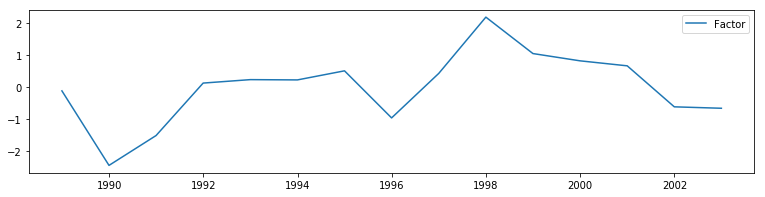

In [17]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

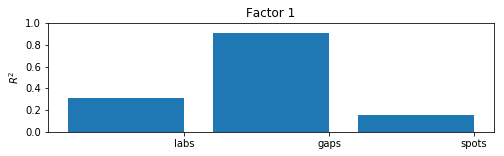

In [18]:
res.plot_coefficients_of_determination(figsize=(8,2));


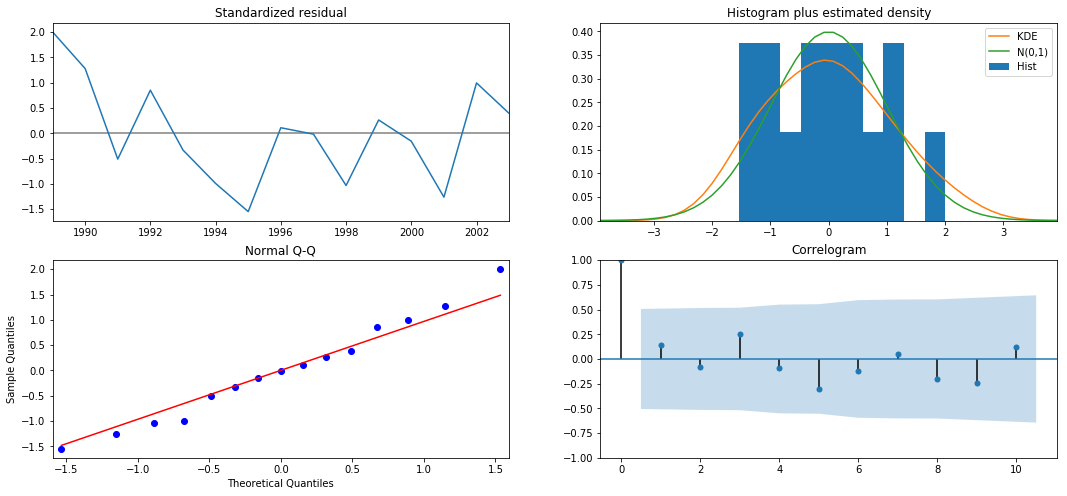

In [19]:
res.plot_diagnostics(figsize=(18, 8))
plt.show()

## Un-smoothed time-series

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                   Statespace Model Results                                  
Dep. Variable:             ['labs', 'gaps', 'spots']   No. Observations:                   15
Model:             DynamicFactor(factors=1, order=1)   Log Likelihood                 -56.728
                                      + AR(1) errors   AIC                            133.456
Date:                               Tue, 07 Apr 2020   BIC                            140.536
Time:                                       12:03:11   HQIC                           133.380
Sample:                                   12-31-1988                                         
                                        - 12-31-2002                                         
Covariance Type:                                 opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

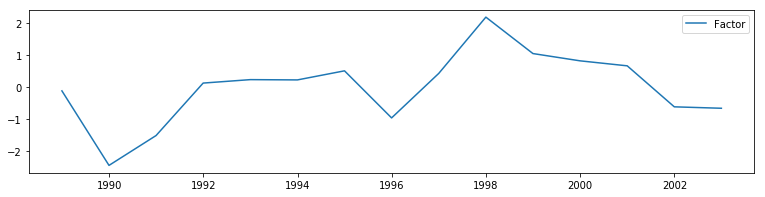

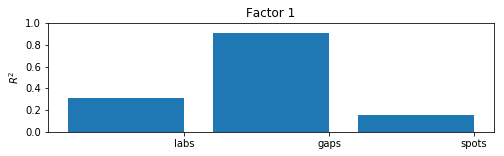

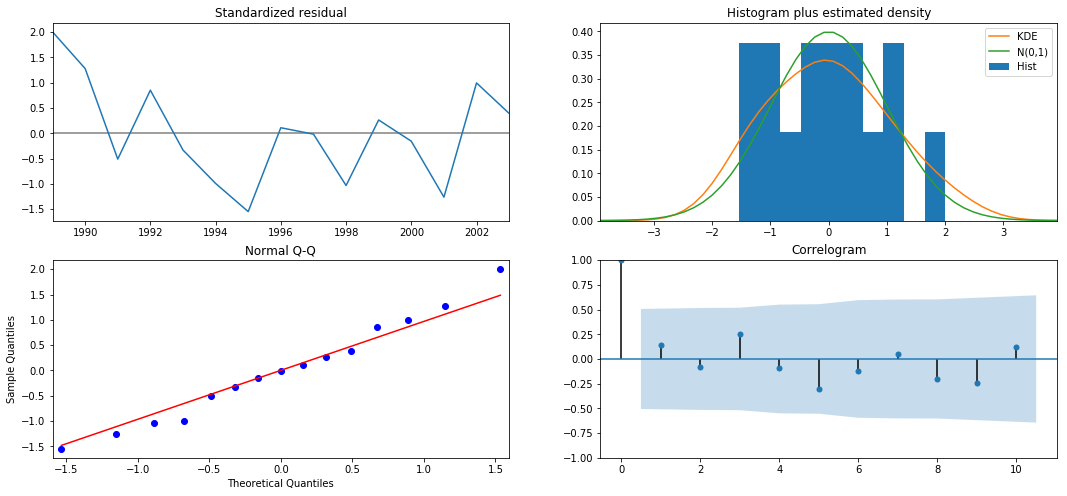

In [20]:
df1 = pd.DataFrame(offsets_labs)
df2 = pd.DataFrame(offsets_gaps)
df3 = pd.DataFrame(offsets_spots)


df1.rename(columns={"offset50_mean": "labs"},inplace=True)
df2.rename(columns={"offset50_mean": "gaps"},inplace=True)
df3.rename(columns={"offset50_mean": "spots"},inplace=True)



endog = df1.join(df2, how='outer')
endog = endog.join(df3, how='outer')


endog['spots'] = (endog['spots'] - endog['spots'].mean()) / endog['spots'].std()
endog['gaps'] = (endog['gaps'] - endog['gaps'].mean()) / endog['gaps'].std()
endog['labs'] = (endog['labs'] - endog['labs'].mean()) / endog['labs'].std()


import statsmodels.api as sm

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

print(res.summary(separate_params=False))


fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

res.plot_coefficients_of_determination(figsize=(8,2));


res.plot_diagnostics(figsize=(18, 8))
plt.show()

# Summary

- No clear correlation between network centrality and rainfall (some correlation observed for gaps, but the reasons why it is observed here and not in the other points are not clear).

- Fitted factors seem to be compatible with 0.